In [1]:
import os
import torch
import matplotlib.pyplot as plt
from src.data_generation import generate_data
from hydra import compose, initialize
from omegaconf import OmegaConf

# load config using hydra
with initialize(version_base=None, config_path="config", job_name="test_app"):
    cfg = compose(config_name="config")

In [2]:
cfg.data.N = 10
cfg.graph.graph_type = 'RANDOM'

In [3]:
device = torch.device('cpu')

# generate data and move to device
X, y, graph_filters_flat, weight_matrix, filter_coefficients = [d.to(device) for d in generate_data(cfg)]

In [4]:
y.shape

torch.Size([10000, 10, 1])

100%|██████████| 9750/9750 [00:26<00:00, 362.57it/s, MA y error=52.1]


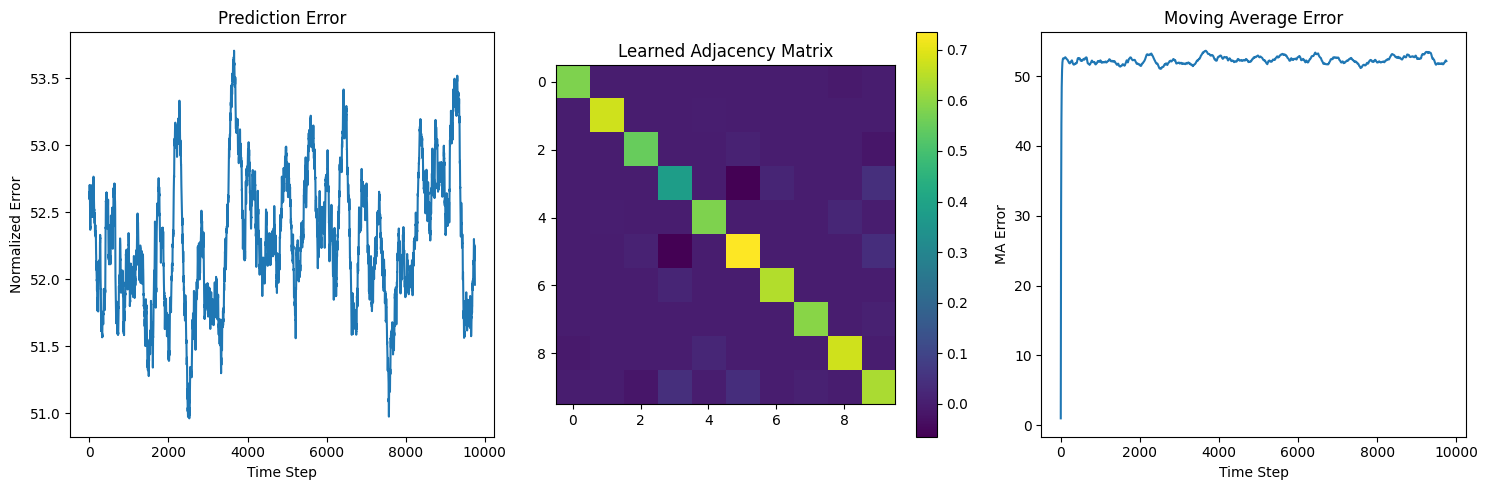

Final number of non-zero elements: 32


In [5]:
from src.models.baselines.GraphLasso import GraphLasso

# Set up hyperparameters
hyperparams = {
    'P_cov': 250,          # Window size for covariance estimation
    'alpha': 0.1,          # Regularization parameter for Lasso
    'patience': None,        # Patience for early stopping
    'min_delta_percent': 0.01,  # Minimum improvement threshold
    'ma_alpha': 0.1,       # Moving average coefficient
}

# Assuming you have your data in 'y' format
# y should be a numpy array with shape (samples, nodes, features)
# where usually features=1 for time series

# Number of nodes in your network
N = y.shape[1]

# Create the NodeWiseLasso instance
model = GraphLasso(N=N, hyperparams=hyperparams, device='cpu')

# Run the model
results = model.run(y, weight_matrix, append_all_matrices=True)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot prediction error
plt.subplot(131)
plt.plot(results['pred_error'])
plt.title('Prediction Error')
plt.xlabel('Time Step')
plt.ylabel('Normalized Error')

# Plot the latest learned adjacency matrix
plt.subplot(132)
plt.imshow(results['matrices'][-1], cmap='viridis')
plt.colorbar()
plt.title('Learned Adjacency Matrix')

# Plot moving average error
plt.subplot(133)
plt.plot(results['pred_error_recursive_moving_average'])
plt.title('Moving Average Error')
plt.xlabel('Time Step')
plt.ylabel('MA Error')

plt.tight_layout()
plt.show()

print(f"Final number of non-zero elements: {results['num_non_zero_elements'][-1] if 'num_non_zero_elements' in results and results['num_non_zero_elements'] else 'N/A'}")

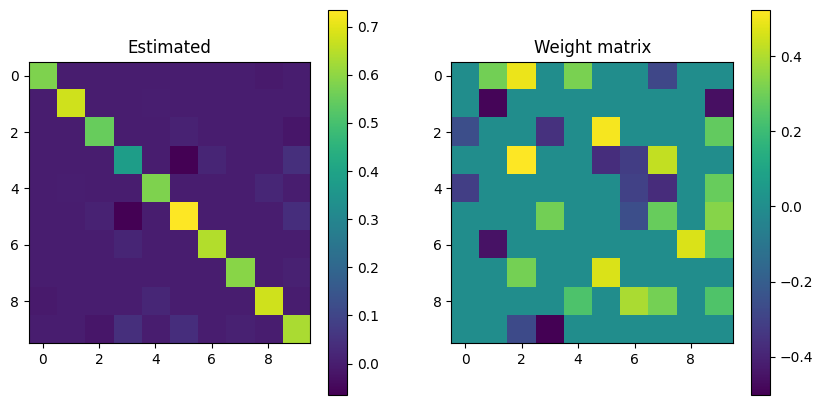

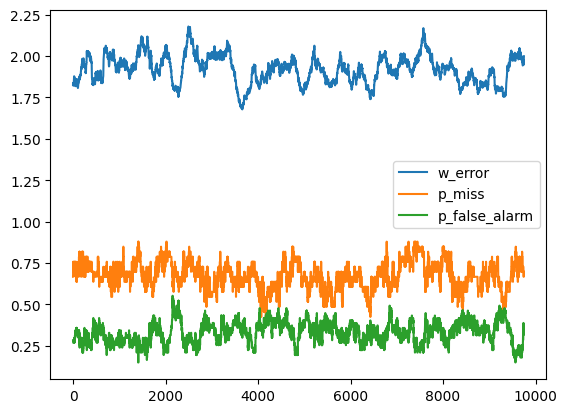

In [6]:
# plot the precision matrix and the weight matrix side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(results['matrices'][-1])
plt.title('Estimated')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(weight_matrix.cpu().numpy())
plt.title('Weight matrix')
plt.colorbar()
plt.show()

plt.plot(results['w_error'], label='w_error')
plt.plot(results['p_miss'], label='p_miss')
plt.plot(results['p_false_alarm'], label='p_false_alarm')
plt.legend()

  0%|          | 0/9500 [00:00<?, ?it/s]

  2%|▏         | 206/9500 [00:22<16:34,  9.34it/s, MA y error=0.549]


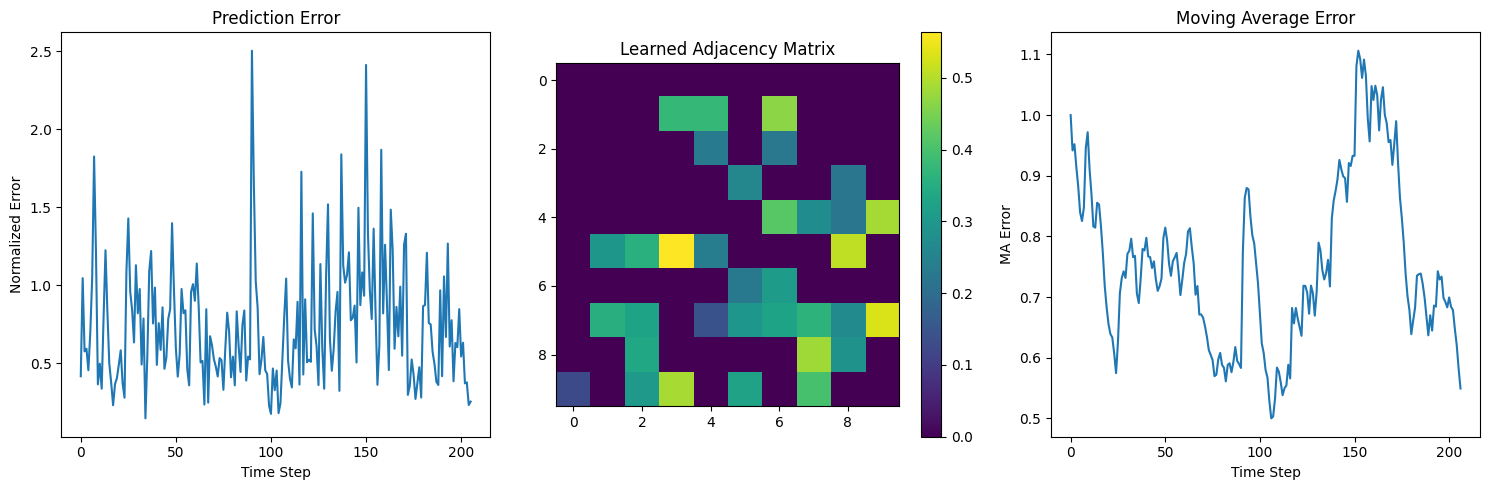

Final number of non-zero elements: 34


In [7]:
from src.models.baselines.GrangerVAR import GrangerVAR

# Set up hyperparameters
hyperparams = {
    'P_window': 500,          # Window size for covariance estimation
    'alpha': 0.1,          # Regularization parameter for Lasso
    'patience': 100,        # Patience for early stopping
    'min_delta_percent': 0.01,  # Minimum improvement threshold
    'ma_alpha': 0.1,       # Moving average coefficient
    'P': 3,
    'use_granger_causality': True
}

# Assuming you have your data in 'y' format
# y should be a numpy array with shape (samples, nodes, features)
# where usually features=1 for time series

# Number of nodes in your network
N = y.shape[1]

# Create the NodeWiseLasso instance
model = GrangerVAR(N=N, hyperparams=hyperparams, device='cpu')

# Run the model
results = model.run(y, weight_matrix, append_all_matrices=True)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot prediction error
plt.subplot(131)
plt.plot(results['pred_error'])
plt.title('Prediction Error')
plt.xlabel('Time Step')
plt.ylabel('Normalized Error')

# Plot the latest learned adjacency matrix
plt.subplot(132)
plt.imshow(results['matrices'][-1], cmap='viridis')
plt.colorbar()
plt.title('Learned Adjacency Matrix')

# Plot moving average error
plt.subplot(133)
plt.plot(results['pred_error_recursive_moving_average'])
plt.title('Moving Average Error')
plt.xlabel('Time Step')
plt.ylabel('MA Error')

plt.tight_layout()
plt.show()

print(f"Final number of non-zero elements: {results['num_non_zero_elements'][-1] if 'num_non_zero_elements' in results and results['num_non_zero_elements'] else 'N/A'}")

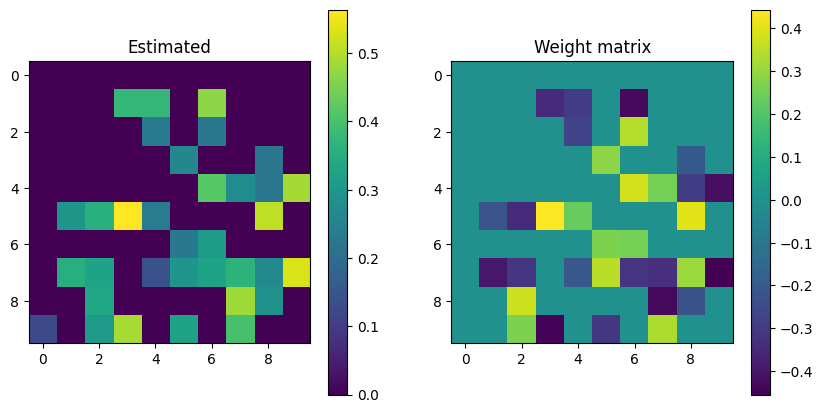

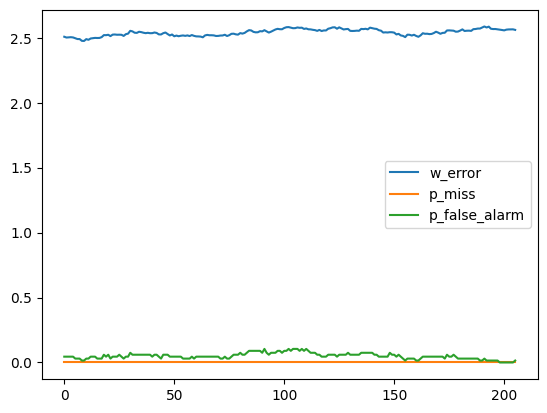

In [8]:
# plot the precision matrix and the weight matrix side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(results['matrices'][-1])
plt.title('Estimated')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(weight_matrix.cpu().numpy())
plt.title('Weight matrix')
plt.colorbar()
plt.show()

plt.plot(results['w_error'], label='w_error')
plt.plot(results['p_miss'], label='p_miss')
plt.plot(results['p_false_alarm'], label='p_false_alarm')
plt.legend()

In [8]:
import numpy as np
import torch
import inspect

from tqdm import tqdm
from src.line_search import wolfe_line_search
from src.utils import get_each_graph_filter, pack_graph_filters

class AdaCGPLaplacian:
    """Adaptive Causal Graph Process model with Laplacian constraints
    """
    def __init__(self, N, hyperparams, device):
        self.N = N
        self.device = device
        self.set_hyperparameters(hyperparams)
        self.initialize_parameters()
        self._check_private_variables()

    def _check_private_variables(self):
        # Get all attributes of the class
        attributes = inspect.getmembers(self, lambda a: not inspect.isroutine(a))
        
        # Filter for private attributes (starting with underscore)
        private_attrs = [a for a in attributes if a[0].startswith('_') and not a[0].startswith('__')]
        
        # Check if each private attribute is defined
        undefined_attrs = [attr for attr, value in private_attrs if value is None]
        
        if undefined_attrs:
            raise AttributeError(f"The following private attributes are not defined: {', '.join(undefined_attrs)}")

    def initialize_parameters(self):
        N, P, device = self.N, self._P, self.device
        
        self.Psi_pos = torch.zeros((N, N*P), dtype=torch.float32, device=device)
        self.Psi_neg = torch.zeros((N, N*P), dtype=torch.float32, device=device)
        self.Psi = torch.zeros((N, N*P), dtype=torch.float32, device=device)
        self.P0 = torch.zeros((N, N*P), dtype=torch.float32, device=device)
        self.Q = torch.zeros((N, N*P), dtype=torch.float32, device=device)
        self.R0 = torch.zeros((N*P, N*P), dtype=torch.float32, device=device)
        self.W = torch.zeros((N, N), dtype=torch.float32, device=device)
        self.W_pos = torch.zeros((N, N), dtype=torch.float32, device=device)
        self.W_neg = torch.zeros((N, N), dtype=torch.float32, device=device)
        self.M = int(P * (P + 3) / 2)
        self.h = torch.zeros((self.M, 1), dtype=torch.float32, device=device)
        # self.h[1] = 1
        self.C = torch.zeros((self.M, self.M), dtype=torch.float32, device=device)
        self.u = torch.zeros((self.M, 1), dtype=torch.float32, device=device)
        self.eye_NxN = torch.eye(N, N, device=device)
        self.ones_NxN = torch.ones_like(self.eye_NxN)
        self.eye_N = torch.eye(N, device=device)
        self.ones_N = torch.ones(N, 1, dtype=torch.float32, device=device)
        self.eye_P = torch.eye(P, device=device)
        self.mus = torch.tensor(self.mus, dtype=torch.float32, device=device)

        # parameters for constrained algorithm
        self.r_c_matrix = torch.zeros(P, P, dtype=torch.float32, device=device)
        self.r_phi_matrix = torch.zeros(P, 1, dtype=torch.float32, device=device)
        self.p_c_matrix = torch.zeros(P, 1, dtype=torch.float32, device=device)
        self.c = torch.zeros(P, 1, dtype=torch.float32, device=device)
        self.lagrange = torch.zeros(N*P, 1, dtype=torch.float32, device=device)
        self.lagrange2 = torch.zeros(N, 1, dtype=torch.float32, device=device)

        assert self._decay_percent <= 100 and self._decay_percent >= 0, "decay_percent must be between 0 and 100"
        self.T = int(np.ceil(-1 + np.log(self._decay_percent / 100) / np.log(self._lambda)))
        self.Lambda_ = torch.tensor([self._lambda**(self.T-1-i) for i in range(0, self.T)], device=device).unsqueeze(-1).to(torch.float32)
    
    def set_hyperparameters(self, hyperparams):
        for param, value in hyperparams.items():
            setattr(self, f"_{param}", value)

    def __getattr__(self, name):
        if name.startswith('_'):
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
        private_name = f"_{name}"
        if hasattr(self, private_name):
            return getattr(self, private_name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
    
    def _get_filter(self, c, psi):
        return torch.kron(c.T, self.eye_NxN) + psi

    def reshape_matrix(self, S, forward=True):
        if forward:
            return S.reshape(self.N, self._P, self.N).permute(2, 1, 0).reshape(self.N, self.N*self._P).T
        return S.T.reshape(self.N, self._P, self.N).permute(2, 1, 0).reshape(self.N, self.N*self._P)

    def laplacian_projection(self, pos_elements, neg_elements):
        # enforce positive diagonal and negative off diagonal for the Laplacian
        pos_elements[:self.N, :self.N] = torch.diag(torch.diag(pos_elements[:self.N, :self.N]))
        neg_elements[:self.N, :self.N] = neg_elements[:self.N, :self.N] - torch.diag(torch.diag(neg_elements[:self.N, :self.N]))
        return pos_elements, neg_elements

    def run(self, X, y, weight_matrix=None, filter_coefficients=None, graph_filter_matrix=None, **kwargs):
        """Run the AdaCGP model

        Args:
            X (torch.tensor): input data (T, N, P)
            y (torch.tensor): target data (T, N)
            weight_matrix (torch.tensor, optional): true weight matrix, if known. Defaults to None.
            filter_coefficients (torch.tensor, optional): true filter coefficients if known. Defaults to None.
            graph_filter_matrix (torch.tensor, optional): true graph filter matrix if known. Defaults to None.
        """

        results = {
            'pred_error': [], 'pred_error_from_h': [], 'filter_error': [],
            'w_error': [], 'coeff_errors': [], 'first_alg_converged_status': [],
            'second_alg_converged_status': [], 'matrices': [], 'p_miss': [], 'p_false_alarm': [], 'psi_losses': [],
            'percentage_correct_elements': [], 'num_non_zero_elements': [],
            'prob_miss': [], 'prob_false_alarm': [], 'pred_error_recursive_moving_average': [1],
            'pred_error_recursive_moving_average_h': [1]
        }
 
        switch_algorithm = False
        first_alg_converged = False
        second_alg_converged = False
        lowest_error = 1e10
        psi_loss = 0.0
        mask = None
        process_length = X.shape[0]
        with torch.no_grad():
            with tqdm(range(self.T, process_length)) as pbar:
                for t in pbar:
                    ##################################
                    ######### GET DATA AT T ##########
                    ##################################

                    # store the historical values in window T
                    self.X_window = X[t-self.T:t].permute(2, 1, 0)  # (N, P, T)

                    xPt = X[t, :, :].flatten()[:, None]  # (NP, 1)
                    yt = y[t]  # (N, 1)

                    if self._alternate:
                        switch_algorithm = (t % 2 == 0)

                    if self._alternate:
                        ma_error = results[self._monitor_debiasing][-1]
                    elif not first_alg_converged:
                        ma_error = results['pred_error_recursive_moving_average'][-1]
                    else:
                        ma_error = results[self._monitor_debiasing][-1]

                    ##################################
                    ######### CHECK CONVERGENCE ######
                    ##################################
                    if not self._alternate:
                        if not second_alg_converged:
                            if lowest_error != 0:
                                relative_improvement = (lowest_error - ma_error) / lowest_error
                            else:
                                relative_improvement = float('inf') if ma_error < lowest_error else 0

                            if relative_improvement > self._min_delta_percent:
                                lowest_error = ma_error
                                patience_left = self._patience
                            else:
                                patience_left -= 1

                            if patience_left == 0:
                                if not first_alg_converged:
                                    first_alg_converged = True
                                    if not self._alternate:
                                        switch_algorithm = True
                                    patience_left = self._burn_in_debiasing
                                    lowest_error = 1e10
                                else:
                                    second_alg_converged = True
                                    patience_left = self._patience
                        else:
                            patience_left -= 1
                            if patience_left == 0:
                                break
                    else:
                        # alternating
                        if lowest_error != 0:
                            relative_improvement = (lowest_error - ma_error) / lowest_error
                        else:
                            relative_improvement = float('inf') if ma_error < lowest_error else 0

                        if relative_improvement > self._min_delta_percent:
                            lowest_error = ma_error
                            patience_left = self._patience
                        else:
                            if t > self._patience:
                                patience_left -= 1

                        if patience_left == 0:
                            break

                    # Psi loss update
                    psi_loss = 0.5 * (self._lambda * psi_loss + torch.norm(yt - torch.matmul(self._get_filter(self.c, self.Psi), xPt))**2)
                    results['psi_losses'].append(psi_loss.item())
            
                    if not switch_algorithm:
                        ############################################
                        ############## COMPUTE PSI #################
                        ############################################
            
                        self.R0 = self._lambda * self.R0 + torch.matmul(xPt, xPt.T)
                        self.P0 = self._lambda * self.P0 + torch.matmul(yt, xPt.T)
            
                        # Compute mus
                        mu_scales = []
                        Q_unpacked = get_each_graph_filter(self.Q, self.N, self._P)
                        P0_unpacked = get_each_graph_filter(self.P0, self.N, self._P)
                        for p in range(0, self._P):
                            Qp = Q_unpacked[:, p, :]
                            P0p = P0_unpacked[:, p, :]
                            infty_norm = torch.norm(P0p - self._gamma * Qp, p=float('inf'))
                            mu_scales.append(infty_norm)

                        mus_pt = self.mus * torch.stack(mu_scales)
                        M = torch.vstack([self.ones_NxN * mus_pt[p] for p in range(0, self._P)]).T  # (N, N*P)
            
                        include_comm_term = not self._use_path_1

                        if include_comm_term:
                            Qs = []
                            filt = self._get_filter(self.c, self.Psi)
                            Psi_unpacked = get_each_graph_filter(filt, self.N, self._P)
                            for p in range(0, self._P):
                                Qp = comm_term_mnlms(Psi_unpacked, p, self._P)
                                Qs.append(Qp)
                            self.Q = pack_graph_filters(Qs, self.N, self._P)
                            G = torch.matmul(self.Psi, self.R0) - (self.P0 - self._gamma * self.Q)
                        else:
                            G = torch.matmul(self.Psi, self.R0) - self.P0
                        

                        if self._use_constraints_in_step1:
                            C = torch.kron(self.c.T, self.eye_NxN)
                            l_matrix = self.lagrange @ self.ones_N.T
                            l_matrix = self.reshape_matrix(l_matrix, forward=False)
                            G += C @ self.R0

                            # add lagrange term to the gradient
                            G += l_matrix 
                            if self._use_augmented_lagrange:
                                # add augmented lagrange term to the gradient
                                row_sum_constraint  = self.reshape_matrix(self.Psi, forward=True) @ self.ones_N - 0
                                G += self.reshape_matrix(self._rho * (row_sum_constraint @ self.ones_N.T), forward=False)

                        # set maximum stepsize using max eigenvalue of autocorrelation matrix
                        eigs = torch.lobpcg(self.R0, largest=True)
                        psi_stepsize = 2 / (eigs[0].item())
                        A = self.eye_P * psi_stepsize
                        for p in range(self._P):
                            A[p, p] /= (torch.linalg.norm(xPt[p*self.N:(p+1)*self.N], ord=2)**2 + self._epsilon)
            
                        if self.use_armijo and (t > self._warm_up_steps):
                            # Line search
                            Psi_unpacked = get_each_graph_filter(self.Psi, self.N, self._P)
                            direction_unpacked = get_each_graph_filter(G, self.N, self._P)
                            for p in range(0, self._P):
                                alpha = wolfe_line_search(
                                    objective_function_psi_mlms,
                                    gradient_function_psi_mlms,
                                    update_function_psi_mlms,
                                    Psi_unpacked[:, p, :].flatten(),
                                    step_init=A[p, p],
                                    beta=0.5,
                                    args=(self.Psi.clone(), mus_pt, self.R0, self.P0, self._gamma, p, include_comm_term, self.N, self._P, self._lambda, xPt, yt, psi_loss),
                                    max_iter=10
                                )
                                A[p, p] = alpha

                        ######### UPDATE PSI PARAM #########
                        dPsi_pos = - (M + G) @ torch.kron(A, self.eye_N)
                        dPsi_neg = - (M - G) @ torch.kron(A, self.eye_N)
                        self.Psi_pos = self.Psi_pos + dPsi_pos
                        self.Psi_neg = self.Psi_neg + dPsi_neg

                        # projection onto non-negative space
                        self.Psi_pos[self.Psi_pos < 0] = 0
                        self.Psi_neg[self.Psi_neg < 0] = 0

                        # additional gradient projections using the Laplacian inductive bias
                        if self._use_projections_in_step1:
                            self.Psi_pos, self.Psi_neg = self.laplacian_projection(self.Psi_pos, self.Psi_neg)
                        self.Psi = self.Psi_pos - self.Psi_neg
            
                        ######### UPDATE C PARAM ##############
                        XPt = xPt.reshape(self.P, self.N).T  # unvec

                        # update the matrices
                        self.r_c_matrix = self._lambda * self.r_c_matrix + XPt.T @ XPt
                        self.p_c_matrix = self._lambda * self.p_c_matrix + XPt.T @ yt
                        
                        # compute using truncated sum
                        A = torch.einsum('npt,nkt->pkt',
                                        self.X_window,
                                        torch.stack([self.Psi]*self.T).permute(1, 2, 0))  # (N, P, T)
                        B = torch.einsum('pkt,kt->pt',
                                            A,
                                            self.X_window.permute(1, 0, 2).reshape(self.N*self.P, self.T))
                        self.r_phi_matrix = torch.einsum('pt,tn->pn', B, self.Lambda_)

                        # gradient of c
                        c = self.c
                        G_c = self.r_c_matrix @ c + self.r_phi_matrix - self.p_c_matrix
                        if include_comm_term:
                            Qs = []
                            filt = self._get_filter(c, self.Psi)
                            Psi_unpacked = get_each_graph_filter(filt, self.N, self._P)
                            for p in range(0, self._P):
                                Qp = comm_term_c(Psi_unpacked, p, self._P)
                                Qs.append(Qp)
                            
                            Q = torch.stack(Qs, dim=0).unsqueeze(-1)
                            G_c += self._gamma * Q

                        # calculate stepsize
                        eigs = torch.lobpcg(self.r_c_matrix, largest=True)
                        c_step = 2 / (eigs[0].item())
                        A = self.eye_P * c_step
                        for p in range(self._P):
                            A[p, p] /= (torch.linalg.norm(xPt[p*self.N:(p+1)*self.N], ord=2)**2 + self._epsilon)

                        # update
                        self.c = self.c - A @ G_c

                        ######## UPDATE LAGRANGE PARAM ########
                        if self._use_constraints_in_step1:
                            if self._use_augmented_lagrange:
                                step = self._rho
                            else:
                                step = self._lagrange_step
                            self.lagrange = self.lagrange + step * (self.reshape_matrix(self.Psi, forward=True) @ self.ones_N - 0)

                        ############################################
                        ############### COMPUTE W ##################
                        ############################################
                        if self._use_path_1:
                            
                            # compute commutator term
                            filt = self._get_filter(self.c, self.Psi)
                            Psi_unpacked = get_each_graph_filter(filt, self.N, self._P)
                            S = second_comm_term_mnlms(Psi_unpacked, self.W, self._P)
            
                            # Compute gradient
                            Psi_1 = Psi_unpacked[:, 0, :]
                            V = self.W - (Psi_1 - self._gamma * S)

                            # add constraints to the gradient
                            if self._use_constraints_in_step2:
                                V += self.lagrange2 @ self.ones_N.T
                                if self._use_augmented_lagrange:
                                    V += self._rho2 * ((self.W @ self.ones_N - 0) @ self.ones_N.T)

                            # sparsity term
                            M_1 = (self.ones_NxN * mus_pt[0]) / (torch.linalg.norm(xPt[:self.N], ord=2)**2 + self._epsilon)

                            ######## ARMIJO STEPSIZE #######
                            alpha = wolfe_line_search(
                                objective_function_wstep2_lms,
                                gradient_function_wstep2_lms,
                                update_function_wstep2_lms,
                                self.W.flatten(),
                                step_init=self._w_stepsize,
                                beta=0.1,
                                args=(filt.clone(), mus_pt, self._gamma, self.N, self._P, self.lagrange2, self.ones_N, self._use_constraints_in_step2, self._use_augmented_lagrange, self._rho2),
                                max_iter=10
                            )
                            w_stepsize = alpha 
            
                            ######### UPDATE PARAM #########
                            self.W_pos = self.W_pos - w_stepsize * (M_1 + V)
                            self.W_neg = self.W_neg - w_stepsize * (M_1 - V)

                            # gradient projections
                            self.W_pos[self.W_pos < 0] = 0
                            self.W_neg[self.W_neg < 0] = 0

                            if self._use_projections_in_step2:
                                self.W_pos, self.W_neg = self.laplacian_projection(self.W_pos, self.W_neg)
                            self.W = self.W_pos - self.W_neg
                            
                            if self._use_constraints_in_step2:
                                if self._use_augmented_lagrange:
                                    step = self._rho2
                                else:
                                    step = self._lagrange_step2
                                self.lagrange2 = self.lagrange2 + step * (self.W @ self.ones_N - 0)
                        else:
                            Psi_unpacked = get_each_graph_filter(self.Psi, self.N, self._P)
                            self.W = Psi_unpacked[:, 0, :]
                        
                        pbar.set_postfix({'MA y error': ma_error, 'Step': psi_stepsize, 'Converged': switch_algorithm, 'Row sum psi': torch.mean(self.reshape_matrix(self.Psi) @ self.ones_N).item()})

                    else:
                        ############################################
                        ############### DEBIASING ##################
                        ############################################

                        self.R0 = self._lambda * self.R0 + torch.matmul(xPt, xPt.T)
                        self.P0 = self._lambda * self.P0 + torch.matmul(yt, xPt.T)

                        # Compute mus
                        mu_scales = []
                        Q_unpacked = get_each_graph_filter(self.Q, self.N, self._P)
                        P0_unpacked = get_each_graph_filter(self.P0, self.N, self._P)
                        for p in range(0, self._P):
                            Qp = Q_unpacked[:, p, :]
                            P0p = P0_unpacked[:, p, :]
                            infty_norm = torch.norm(P0p - self._gamma * Qp, p=float('inf'))
                            mu_scales.append(infty_norm)

                        mus_pt = self.mus * torch.stack(mu_scales)
            
                        # gradient
                        G = torch.matmul(self.Psi, self.R0) - self.P0

                        # project gradient to non-zero elements of W (fixed from alg 1)
                        if mask is None:
                            masks = []
                            for i in range(self._P):
                                mask = torch.matrix_power(self.W, i+1)
                                masks.append(mask)
                            mask = pack_graph_filters(masks, self.N, self._P)
                        G[mask == 0] = 0

                        if self._use_constraints_in_step1:
                            # add constraint term to the gradient
                            C = torch.kron(self.c.T, self.eye_NxN)
                            l_matrix = self.lagrange @ self.ones_N.T
                            l_matrix = self.reshape_matrix(l_matrix, forward=False)
                            G += C @ self.R0

                            # add lagrange term to the gradient
                            G += l_matrix 
                            if self._use_augmented_lagrange:
                                # add augmented lagrange term to the gradient
                                row_sum_constraint  = self.reshape_matrix(self.Psi, forward=True) @ self.ones_N - 0
                                G += self.reshape_matrix(self._rho * (row_sum_constraint @ self.ones_N.T), forward=False)
            
                        # set maximum stepsize using max eigenvalue of autocorrelation matrix
                        eigs = torch.lobpcg(self.R0, largest=True)
                        psi_stepsize = 2 / (eigs[0].item())
                        A = self.eye_P * psi_stepsize
                        for p in range(self._P):
                            A[p, p] /= (torch.linalg.norm(xPt[p*self.N:(p+1)*self.N], ord=2)**2 + self._epsilon)
            
                        if self._use_armijo and (t > self._warm_up_steps):
                            Psi_unpacked = get_each_graph_filter(self.Psi, self.N, self._P)
                            for p in range(0, self._P):
                                alpha = wolfe_line_search(
                                    objective_function_psi_debias,
                                    gradient_function_psi_debias,
                                    update_function_psi_debias,
                                    Psi_unpacked[:, p, :].flatten(),
                                    step_init=A[p, p],
                                    beta=0.5,
                                    args=(self.Psi.clone(), mus_pt, self.R0, self.P0, 0, p, False, self.N, self._P, self._lambda, xPt, yt, psi_loss, self.W),
                                    max_iter=10
                                )
                                A[p, p] = alpha

                        ######### UPDATE PSI #########
                        self.Psi = self.Psi - torch.matmul(G, torch.kron(A, self.eye_N))
                        Psi_unpacked = get_each_graph_filter(self.Psi, self.N, self._P)

                        ######## UPDATE W #########
                        self.W = Psi_unpacked[:, 0, :]
                        self.W_pos = self.W.clone()
                        self.W_pos[self.W_pos < 0] = 0
                        self.W_neg = self.W.clone()
                        self.W_neg[self.W_neg > 0] = 0
                        self.W_neg *= -1
                        if self._use_projections_in_step1:
                            self.W_pos, self.W_neg = self.laplacian_projection(self.W_pos, self.W_neg)
                            # self.W = self.W_pos + self.W_neg

                        pbar.set_postfix({'MA y error': ma_error, 'Step': psi_stepsize, 'Converged': switch_algorithm, 'Row sum psi': torch.mean(self.reshape_matrix(self.Psi) @ self.ones_N).item()})

                        ####### UPDATE C #########
                        XPt = xPt.reshape(self.P, self.N).T  # unvec

                        # update the matrices
                        self.r_c_matrix = self._lambda * self.r_c_matrix + XPt.T @ XPt
                        self.p_c_matrix = self._lambda * self.p_c_matrix + XPt.T @ yt
                        
                        # compute using truncated sum
                        A = torch.einsum('npt,nkt->pkt',
                                        self.X_window,
                                        torch.stack([self.Psi]*self.T).permute(1, 2, 0))  # (N, P, T)
                        B = torch.einsum('pkt,kt->pt',
                                            A,
                                            self.X_window.permute(1, 0, 2).reshape(self.N*self.P, self.T))
                        self.r_phi_matrix = torch.einsum('pt,tn->pn', B, self.Lambda_)

                        # gradient of c
                        G_c = self.r_c_matrix @ self.c + self.r_phi_matrix - self.p_c_matrix
                        if include_comm_term:
                            Qs = []
                            filt = self._get_filter(self.c, self.Psi)
                            Psi_unpacked = get_each_graph_filter(filt, self.N, self._P)
                            for p in range(0, self._P):
                                Qp = comm_term_c(Psi_unpacked, p, self._P)
                                Qs.append(Qp)
                            
                            Q = torch.stack(Qs, dim=0).unsqueeze(-1)
                            G_c += self._gamma * Q

                        # calculate stepsize
                        eigs = torch.lobpcg(self.r_c_matrix, largest=True)
                        c_step = 2 / (eigs[0].item())
                        A = self.eye_P * c_step
                        for p in range(self._P):
                            A[p, p] /= (torch.linalg.norm(xPt[p*self.N:(p+1)*self.N], ord=2)**2 + self._epsilon)

                        # update
                        self.c = self.c - A @ G_c

                        ######## UPDATE LAGRANGE PARAM ########
                        if self._use_constraints_in_step1:
                            if self._use_augmented_lagrange:
                                step = self._rho
                            else:
                                step = self._lagrange_step
                            self.lagrange = self.lagrange + step * (self.reshape_matrix(self.Psi, forward=True) @ self.ones_N - 0)

                    ############################################
                    ########### COMPUTE FILTER COEFS ###########
                    ############################################

                    Xpt = xPt.view(self._P, self.N)
                    Ys = []
                    for i in range(1, self._P + 1):
                        x_t_m_i = Xpt[i-1, :]
                        for j in range(i + 1):
                            Yij = torch.matmul(torch.matrix_power(self.W, j), x_t_m_i)
                            Ys.append(Yij)
                    Ys = torch.stack(Ys, dim=1)  # (N, M)
            
                    b = torch.sign(self.h) / (self._epsilon + self.h)
                    nu_t = self._nu * torch.norm(torch.matmul(Ys.T, Ys), p=float('inf'))
            
                    if self._instant_h:
                        h_e = yt - torch.matmul(Ys, self.h)
                        h_g = torch.matmul(Ys.T, h_e)
                    else:
                        self.C = self._lambda * self.C + torch.matmul(Ys.T, Ys)
                        self.u = self._lambda * self.u + torch.matmul(Ys.T, yt)
                        h_g = torch.matmul(self.C, self.h) - self.u

                    ######## ARMIJO STEPSIZE #######
                    alpha = wolfe_line_search(
                        objective_function_h_lms,
                        gradient_function_h_lms,
                        update_function_h_lms,
                        self.h.flatten(),
                        step_init=self._h_stepsize,
                        beta=0.5,
                        args=(Ys, yt, self._lambda, self.C, self.u, self._instant_h, nu_t, self._epsilon),
                        max_iter=10
                    )
                    h_stepsize = alpha
            
                    ######### UPDATE PARAM #########
                    dh = h_g + nu_t * b
                    self.h = self.h + h_stepsize * dh
                    d_hat_h = torch.matmul(Ys, self.h)

                    ###################################
                    ######### COMPUTE RESULTS #########
                    ###################################

                    # Compute squared error of signal forecast from graph filters
                    d_hat_psi = torch.matmul(self.Psi, xPt)
                    e = yt - d_hat_psi
                    norm_error = torch.norm(e)**2 / torch.norm(yt)**2
                    results['pred_error'].append(norm_error.item())
                    ma_error = self._ma_alpha * norm_error + (1 - self._ma_alpha) * results['pred_error_recursive_moving_average'][-1]
                    results['pred_error_recursive_moving_average'].append(ma_error.item())
            
                    # Compute the prediction error from h
                    h_e = yt - d_hat_h
                    norm_h_error = torch.norm(h_e)**2 / torch.norm(yt)**2
                    results['pred_error_from_h'].append(norm_h_error.item())
                    ma_error_h = self._ma_alpha * norm_h_error + (1 - self._ma_alpha) * results['pred_error_recursive_moving_average_h'][-1]
                    results['pred_error_recursive_moving_average_h'].append(ma_error_h.item())
        
                    # Compute squared error of graph filter estimation
                    if graph_filter_matrix is not None:
                        m_error = graph_filter_matrix - self.Psi
                        norm_m_error = torch.norm(m_error)**2 / torch.norm(graph_filter_matrix)**2
                        results['filter_error'].append(norm_m_error.item())
            
                    # Compute squared error of W estimation
                    if weight_matrix is not None:
                        weight_matrix_error = weight_matrix - self.W
                        norm_w_error = torch.norm(weight_matrix_error)**2 / torch.norm(weight_matrix)**2
                        results['w_error'].append(norm_w_error.item())
                        results['num_non_zero_elements'].append((self.W != 0).sum().item())

                        # compute the percentage of elements correctly identified in W
                        total = (weight_matrix != 0).sum()
                        frac = ((self.W != 0) * (weight_matrix != 0)).sum() / total
                        results['percentage_correct_elements'].append(frac.item())

                        # save results for p_miss: probability of missing a non-zero element in W
                        results['p_miss'].append(((self.W == 0) * (weight_matrix != 0)).sum().item() / (weight_matrix != 0).sum().item())
                        results['p_false_alarm'].append(((self.W != 0) * (weight_matrix == 0)).sum().item() / (weight_matrix == 0).sum().item())
                
                    # Compute the error for filter coefficient estimation
                    if filter_coefficients is not None:
                        coeff_error = filter_coefficients - self.h.flatten()
                        norm_coeff_error = torch.norm(coeff_error)**2 / torch.norm(filter_coefficients)**2
                        results['coeff_errors'].append(norm_coeff_error.item())
                
                    # Store the convergence status
                    results['first_alg_converged_status'].append(first_alg_converged)
                    results['second_alg_converged_status'].append(second_alg_converged)
        results['matrices'].append(self.W.cpu().numpy())
        return results

def comm(A, B):
    return torch.matmul(A, B) - torch.matmul(B, A)
 
def comm_term_mnlms(W, p, P):
    comm_terms = []
    for k in range(P):
        comm_ = torch.matmul(comm(W[:, p, :], W[:, k, :]), W[:, k, :].T) + torch.matmul(W[:, k, :].T, comm(W[:, p, :], W[:, k, :]))
        comm_terms.append(comm_)
    return torch.sum(torch.stack(comm_terms), dim=0)
 
def comm_term_c(W, p, P):
    comm_terms = 0.0
    filt_p = W[:, p, :]
    for k in range(P):
        filt_k = W[:, k, :]
        commute_term = comm(filt_p, filt_k)
        grad_term = torch.trace(filt_k @ commute_term.T) - torch.trace(commute_term.T @ filt_k)
        comm_terms += grad_term
    return comm_terms

def second_comm_term_mnlms(W, A, P):
    comm_terms = []
    for k in range(P):
        comm_ = torch.matmul(comm(A, W[:, k, :]), W[:, k, :].T) + torch.matmul(W[:, k, :].T, comm(A, W[:, k, :]))
        comm_terms.append(comm_)
    return torch.sum(torch.stack(comm_terms), dim=0)
 
def gradient_function_psi_mlms(psi_p_flat, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, **kwargs):
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    psi_p = psi_p_flat.reshape(N, N)
    Psi_unpacked[:, p, :] = psi_p
    Psi = pack_graph_filters([Psi_unpacked[:, i, :] for i in range(P)], N, P)
 
    if include_comm_term:
        Qs = []
        Psi_unpacked = get_each_graph_filter(Psi, N, P)
        for p in range(P):
            Qp = comm_term_mnlms(Psi_unpacked, p, P)
            Qs.append(Qp)
        Q = pack_graph_filters(Qs, N, P)
        G = torch.matmul(Psi, R0) - (P0 - gamma_ * Q)
    else:
        G = torch.matmul(Psi, R0) - P0
    
    G_unpacked = get_each_graph_filter(G, N, P)
    gp = G_unpacked[:, p, :]
    return gp.flatten() # (N*N,)
 
def objective_function_psi_mlms(psi_p_flat, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, **kwargs):
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    psi_p = psi_p_flat.reshape(N, N)
    Psi_unpacked[:, p, :] = psi_p
    Psi = pack_graph_filters([Psi_unpacked[:, i, :] for i in range(P)], N, P)
    psi_loss = 0.5 * (lambda_ * cumulative_loss + torch.norm(yt - torch.matmul(Psi, xPt))**2)
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
 
    for i in range(P):
        Psi_p = Psi_unpacked[:, i, :]
        mu = mus_pt[i]
        psi_loss += mu * torch.norm(Psi_p.flatten(), p=1)
 
        if include_comm_term:
            for j in range(P):
                if i == j:
                    continue
                psi_loss += gamma_ * torch.norm(comm(Psi_unpacked[:, i, :], Psi_unpacked[:, j, :]), p='fro')**2
 
    return psi_loss
 
def update_function_psi_mlms(psi_p_flat, G, step, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, **kwargs):
    new_param = psi_p_flat - step * G
    return new_param
 
def gradient_function_psi_debias(psi_p_flat, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, mask_W, **kwargs):
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    psi_p = psi_p_flat.reshape(N, N)
    Psi_unpacked[:, p, :] = psi_p
    Psi = pack_graph_filters([Psi_unpacked[:, i, :] for i in range(P)], N, P)
 
    G = torch.matmul(Psi, R0) - P0
    masks = []
    for i in range(P):
        mask = torch.matrix_power(mask_W, i+1)
        masks.append(mask)
    mask = pack_graph_filters(masks, N, P)
    G[mask == 0] = 0
    
    G_unpacked = get_each_graph_filter(G, N, P)
    gp = G_unpacked[:, p, :]
    return gp.flatten() # (N*N,)
 
def objective_function_psi_debias(psi_p_flat, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, mask_W, **kwargs):
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    psi_p = psi_p_flat.reshape(N, N)
    Psi_unpacked[:, p, :] = psi_p
    Psi = pack_graph_filters([Psi_unpacked[:, i, :] for i in range(P)], N, P)
    psi_loss = 0.5 * (lambda_ * cumulative_loss + torch.norm(yt - torch.matmul(Psi, xPt))**2)
    return psi_loss
 
def update_function_psi_debias(psi_p_flat, G, step, Psi, mus_pt, R0, P0, gamma_, p, include_comm_term, N, P, lambda_, xPt, yt, cumulative_loss, mask_W, **kwargs):
    new_param = psi_p_flat - step * G
    return new_param

def objective_function_wstep2_lms(W_flat, Psi, mus_pt, gamma_, N, P, lagrange2, ones_N, use_lagrange, use_augmented_lagrange, rho2_, **kwargs):
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    W = W_flat.reshape(N, N)
    Psi_1 = Psi_unpacked[:, 0, :]
    
    wstep2_loss = 0
    wstep2_loss += 0.5 * torch.norm(Psi_1 - W)**2
    wstep2_loss += mus_pt[0] * torch.norm(W, p=1)
    for i in range(1, P):
        wstep2_loss += gamma_ * torch.norm(comm(W, Psi_unpacked[:, i, :]), p='fro')**2

    if use_lagrange:
        wstep2_loss += (lagrange2.T @ (W @ ones_N - 0)).squeeze()
        if use_augmented_lagrange:
            wstep2_loss += 0.5 * rho2_ * torch.norm(W @ ones_N - 0)**2
    return wstep2_loss
 
def gradient_function_wstep2_lms(W_flat, Psi, mus_pt, gamma_, N, P, lagrange2, ones_N, use_lagrange, use_augmented_lagrange, rho2_, **kwargs):
    W = W_flat.reshape(N, N)
    Psi_unpacked = get_each_graph_filter(Psi, N, P)
    Psi_1 = Psi_unpacked[:, 0, :]
    S = second_comm_term_mnlms(Psi_unpacked, W, P)

    # Compute gradient
    Psi_1 = Psi_unpacked[:, 0, :]
    V = W - (Psi_1 - gamma_ * S)
    if use_lagrange:
        V += lagrange2 @ ones_N.T
        if use_augmented_lagrange:
            V += rho2_ * ((W @ ones_N - 0) @ ones_N.T)
    return V.flatten()

def update_function_wstep2_lms(W_flat, G, step, Psi, mus_pt, gamma_, N, P, lagrange2, ones_N, use_lagrange, use_augmented_lagrange, rho2_, **kwargs):
    new_param = W_flat - step * G
    return new_param
 
def objective_function_h_lms(h_flat, Ys, yt, lambda_, C, u, instant_h, nu_t, epsilon):
    h = h_flat.reshape(-1, 1)
    loss = 0
    loss += 0.5 * torch.norm(yt - torch.matmul(Ys, h))**2
    loss += nu_t * torch.norm(h, p=1)
    return loss
 
def gradient_function_h_lms(h_flat, Ys, yt, lambda_, C, u, instant_h, nu_t, epsilon):
    h = h_flat.reshape(-1, 1)
    b = torch.sign(h) / (epsilon + h)
 
    if instant_h:
        h_e = yt - torch.matmul(Ys, h)
        h_g = torch.matmul(Ys.T, h_e)
    else:
        C = lambda_ * C + torch.matmul(Ys.T, Ys)
        u = lambda_ * u + torch.matmul(Ys.T, yt)
        h_g = torch.matmul(C, h) - u
    return (h_g + nu_t * b).flatten()
 
def update_function_h_lms(h_flat, dh, h_stepsize, Ys, yt, lambda_, C, u, instant_h, nu_t, epsilon):
    new_param = h_flat + h_stepsize * dh
    # new_param[0] = 0
    # new_param[1] = 1
    return new_param


In [9]:
y_in = y[:, :, 0].cpu().numpy()

hyperparams = {"P": 3,
               "gamma": 0.1,
               "w_stepsize": 0.001,
               "h_stepsize": 0.001,
               "psi_stepsize": 1e-5,
               "epsilon": 1e-3,
               "lambda": 0.95,
               "nu": 0.01,
               "ma_alpha": 0.005,
               "use_path_1": True,
               "instant_h": True,
               "patience": 500,
               "burn_in_debiasing": 500,
               "min_delta_percent": 0.01,
               "use_armijo": False,
               "warm_up_steps": 0,
               "alternate": False,
               "alternate_mod": 2,
               "monitor_debiasing": 'pred_error_recursive_moving_average',
               "mus": [0.1, 0.1, 0.1],
               "decay_percent": 50,
               "use_constraints_in_step1": False,
               "use_projections_in_step1": False,
               "use_projections_in_step2": False,
               "use_constraints_in_step2": False,
               "use_augmented_lagrange": False,
               "rho": 1e-2,
                "lagrange_step": 1e-2,
               "rho2": 1e-2,
                "lagrange_step2": 1e-2,
               }
device = 'cpu'
model = AdaCGPLaplacian(cfg.data.N, hyperparams, device)
model_inputs = {
    'X': X.to(device),
    'y': y.to(device),
    'weight_matrix': weight_matrix.to(device),
    'filter_coefficients': filter_coefficients.to(device),
    'graph_filters_flat': graph_filters_flat.to(device),
}
results_unconstrained = model.run(**model_inputs)

  3%|▎         | 290/9987 [00:11<06:22, 25.34it/s, MA y error=0.757, Step=0.00867, Converged=0, Row sum psi=-0.0513] 


KeyboardInterrupt: 

In [36]:
y_in = y[:, :, 0].cpu().numpy()

hyperparams = {"P": 3,
               "gamma": 0.1,
               "w_stepsize": 0.001,
               "h_stepsize": 0.001,
               "psi_stepsize": 1e-5,
               "epsilon": 1e-3,
               "lambda": 0.95,
               "nu": 0.01,
               "ma_alpha": 0.005,
               "use_path_1": True,
               "instant_h": True,
               "patience": 500,
               "burn_in_debiasing": 500,
               "min_delta_percent": 0.01,
               "use_armijo": False,
               "warm_up_steps": 0,
               "alternate": False,
               "alternate_mod": 2,
               "monitor_debiasing": 'pred_error_recursive_moving_average',
               "mus": [0.1, 0.1, 0.1],
               "decay_percent": 50,
               "use_constraints_in_step1": True,
               "use_projections_in_step1": True,
               "use_projections_in_step2": True,
               "use_constraints_in_step2": True,
               "use_augmented_lagrange": True,
               "rho": 1e-1,
                "lagrange_step": 1e-4,
               "rho2": 1e-1,
                "lagrange_step2": 1e-4,
               }
device = 'cpu'
model = AdaCGPLaplacian(cfg.data.N, hyperparams, device)
model_inputs = {
    'X': X,
    'y': y,
    'weight_matrix': weight_matrix,
    'filter_coefficients': filter_coefficients,
    'graph_filters_flat': graph_filters_flat
}
results_constrained = model.run(**model_inputs)

 20%|██        | 2031/9987 [00:15<01:00, 131.14it/s, MA y error=7.58e+6, Step=0.0169, Converged=1, Row sum psi=62]    


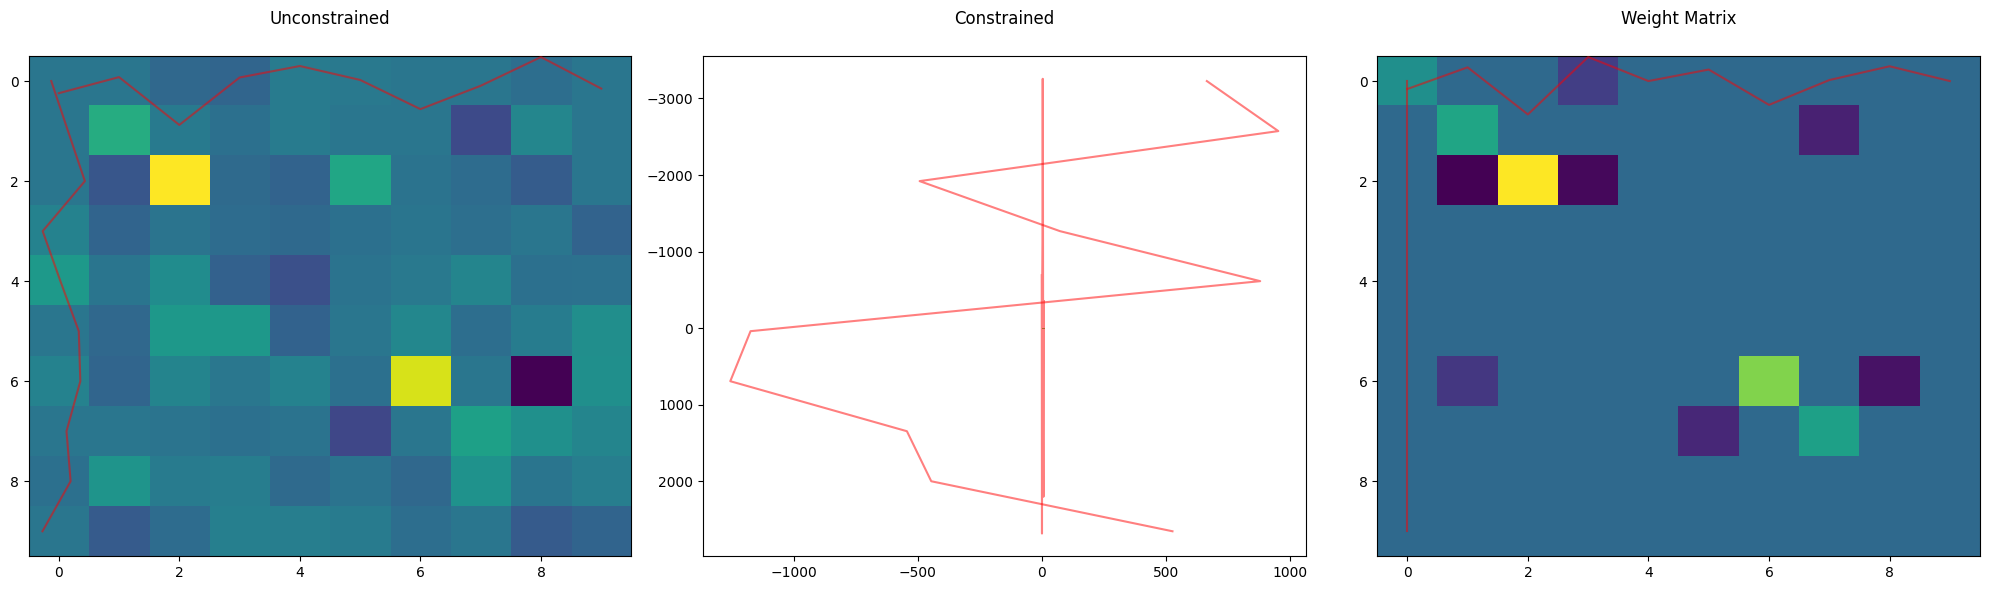

In [38]:
import matplotlib.pyplot as plt

def plot_matrix_with_sums(ax, matrix, title):
    im = ax.imshow(matrix, aspect='auto')
    ax.set_title(title)
    
    # Calculate row and column sums
    row_sums = matrix.sum(axis=1)
    col_sums = matrix.sum(axis=0)
    
    # Plot row sums on the right
    ax_right = ax.twinx()
    ax_right.plot(row_sums, range(len(row_sums)), 'r-', alpha=0.5)
    ax_right.set_ylim(ax.get_ylim())
    ax_right.axis('off')
    
    # Plot column sums on the top
    ax_top = ax.twiny()
    ax_top.plot(range(len(col_sums)), col_sums, 'r-', alpha=0.5)
    ax_top.set_xlim(ax.get_xlim())
    ax_top.axis('off')
    
    return im

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot each matrix
im1 = plot_matrix_with_sums(ax1, results_unconstrained['matrices'][-1], 'Unconstrained')
im2 = plot_matrix_with_sums(ax2, results_constrained['matrices'][-1], 'Constrained')
im3 = plot_matrix_with_sums(ax3, weight_matrix.cpu().numpy(), 'Weight Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

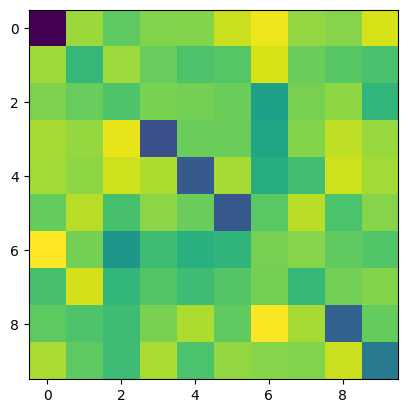

In [39]:
plt.imshow(results_constrained['matrices'][-1])

In [ ]:
import numpy as np

patience=200
pred_error = np.array(results['pred_error'])
alg1_in_steady_state = np.zeros_like(pred_error, dtype=bool)
alg1_in_steady_state[-patience:] = True

metrics = {
    'nmse_pred': np.array(results['pred_error']),
    'nmse_w': np.array(results['w_error']),
    'pce': np.array(results['percentage_correct_elements']),
    'p_miss': np.array(results['p_miss']),
    'p_false_alarm': np.array(results['p_false_alarm'])
}

algorithms = {
    'alg1': alg1_in_steady_state
}

for alg_name, alg_state in algorithms.items():
    for metric_name, metric_values in metrics.items():
        mean_value = np.mean(metric_values[alg_state])
        print(f"{metric_name}_{alg_name}: {mean_value:.9f}\n")